In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Part B : Fine-tuning a pre-trained model

## Fine-Tuning ResNet/Inception with Weights & Biases (W&B)

This script performs fine-tuning of a pre-trained image classification model (ResNet-50 or Inception V3) on the iNaturalist 12K dataset using PyTorch and automates hyperparameter tuning using Weights & Biases (W&B) sweeps.

---

### 1. **Device Configuration**
- Automatically detects GPU (`cuda`) or defaults to CPU.

---

### 2. **Model Loading & Freezing (`get_model`)**
- Supports two architectures: `resnet` and `inception`.
- Loads pre-trained weights using torchvision.
- Replaces the final classification layer to match the 10 output classes.
- Supports two freezing strategies:
  - `last_only=True`: Freeze all layers except the final layer.
  - `freeze_ratio`: Freeze a portion of the earlier layers based on ratio.

---

### 3. **Dataset Preparation (`prepare_data`)**
- Loads data using `ImageFolder`.
- Applies optional data augmentation (e.g., random crops, flips, color jitter).
- Splits data into training and validation sets using `train_test_split`.
- Returns PyTorch DataLoaders for both sets.

---

### 4. **Training Loop (`run_training`)**
- Trains the model using the Adam optimizer and cross-entropy loss.
- Tracks training and validation accuracy across epochs.
- Logs metrics to W&B in real-time.
- Saves a plot of training/validation accuracy at the end.

---

### 5. **Hyperparameter Sweep Setup**
- Uses a W&B sweep to automate experiment tuning.
- Configuration includes:
  - `architecture`: model type (`resnet`, `inception`)
  - `freeze_ratio`: how much of the model to freeze
  - `epochs`: number of training epochs

---

### 6. **Sweep Runner Function (`sweep_runner`)**
- Initializes each sweep run.
- Loads the model and dataset based on sweep config.
- Calls the training loop and logs results.
- Supports easy experimentation via W&B dashboard.

---

### 7. **Launching the Sweep**
- Logs into W&B using API key.
- Initializes a sweep with defined configuration.
- Starts the sweep agent to run experiments.

---

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: 9tmq2zly
Sweep URL: https://wandb.ai/viinod9-iitm/A2_PartB_finetune_random/sweeps/9tmq2zly


wandb: Agent Starting Run: sphsp936 with config:
wandb: 	architecture: resnet
wandb: 	epochs: 6
wandb: 	freeze_ratio: 0.8
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 225MB/s]


Epoch 1/6 | Train Acc: 65.08% | Val Acc: 75.55%
Epoch 2/6 | Train Acc: 77.73% | Val Acc: 77.95%
Epoch 3/6 | Train Acc: 80.39% | Val Acc: 79.30%
Epoch 4/6 | Train Acc: 82.35% | Val Acc: 80.60%
Epoch 5/6 | Train Acc: 83.42% | Val Acc: 80.65%
Epoch 6/6 | Train Acc: 84.75% | Val Acc: 80.55%
Training finished.
Saved accuracy plot as arch-resnet_freeze-0.8_ep-6.png


Epoch,▁▂▄▅▇█
Train Accuracy,▁▆▆▇██
Train Loss,█▄▂▂▁▁
Validation Accuracy,▁▄▆███
Epoch,6
Train Accuracy,84.74809
Train Loss,0.49958
Validation Accuracy,80.55


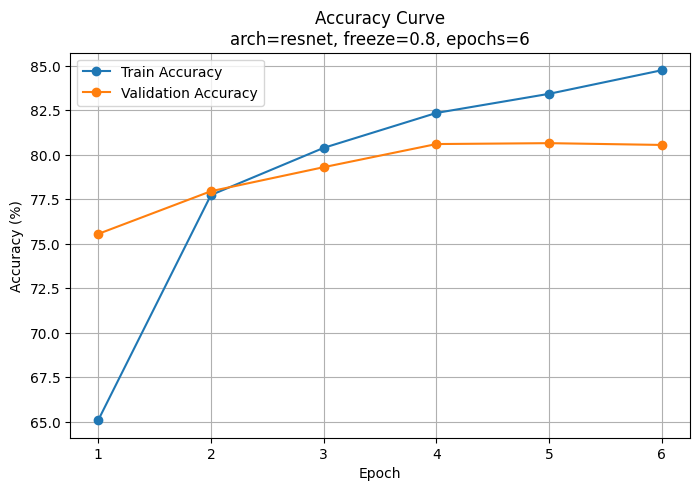

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
import wandb

# Setup for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def get_model(name, freeze_ratio, last_only=False):
    if name == 'resnet':
        weights = ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)

    elif name == 'inception':
        weights = Inception_V3_Weights.DEFAULT
        model = models.inception_v3(weights=weights)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)

    if last_only:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True
    else:
        total = sum(1 for _ in model.children())
        freeze_layers = int(freeze_ratio * total)
        for idx, child in enumerate(model.children()):
            for param in child.parameters():
                param.requires_grad = idx >= freeze_layers

    return model


# Dataset loader
def prepare_data(data_path, augment=False):
    if augment:
        tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    else:
        tfms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    full_data = ImageFolder(data_path, transform=tfms)
    train_idx, val_idx = train_test_split(range(len(full_data)), test_size=0.2, random_state=42)
    train_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(train_idx))
    val_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(val_idx))
    return train_loader, val_loader

import matplotlib.pyplot as plt

def run_training(model, train_dl, val_dl, num_epochs, cfg):
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_dl)
        train_acc = 100 * correct / total
        train_acc_list.append(train_acc)

        wandb.log({"Train Loss": avg_loss, "Train Accuracy": train_acc})

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_acc = 100 * correct_val / total_val
        val_acc_list.append(val_acc)

        wandb.log({"Validation Accuracy": val_acc, "Epoch": epoch + 1})

        # Print accuracy
        print(f"Epoch {epoch + 1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    print("Training finished.")

    # Plot and save
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Accuracy", marker='o')
    plt.plot(range(1, num_epochs + 1), val_acc_list, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curve\narch={cfg.architecture}, freeze={cfg.freeze_ratio}, epochs={cfg.epochs}")
    plt.legend()
    plt.grid(True)
    
    filename = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}.png"
    plt.savefig(filename)
    print(f"Saved accuracy plot as {filename}")


# WandB Sweep setup
sweep_configuration = {
    'method': 'random',
    'metric': {'name': 'Validation Accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [20]},
        'freeze_ratio': {'values': [0.8]},
        'architecture': {'values': ['resnet']}  # You can add 'inception' here
    }
}

# Replace with your own API key
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")
sweep_id = wandb.sweep(sweep=sweep_configuration, project="A2_PartB_finetune_random")


def sweep_runner():
    with wandb.init() as run:
        cfg = wandb.config
        wandb.run.name = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}"

        model = get_model(cfg.architecture, cfg.freeze_ratio, last_only=False)
        data_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"
        train_dl, val_dl = prepare_data(data_dir, augment=False)

        # Pass cfg to run_training
        run_training(model, train_dl, val_dl, num_epochs=cfg.epochs, cfg=cfg)


# Launch sweep
wandb.agent(sweep_id, function=sweep_runner, count=1)
wandb.finish()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: v65fyg5y
Sweep URL: https://wandb.ai/viinod9-iitm/A2_PartB_finetune_bayes/sweeps/v65fyg5y


wandb: Agent Starting Run: zc0p9t4l with config:
wandb: 	architecture: resnet
wandb: 	augment: False
wandb: 	epochs: 10
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.01


Epoch 1/10 | Train Acc: 68.62% | Val Acc: 76.30%
Epoch 2/10 | Train Acc: 78.78% | Val Acc: 77.70%
Epoch 3/10 | Train Acc: 80.95% | Val Acc: 77.90%
Epoch 4/10 | Train Acc: 83.41% | Val Acc: 77.90%
Epoch 5/10 | Train Acc: 84.84% | Val Acc: 76.75%
Epoch 6/10 | Train Acc: 85.44% | Val Acc: 76.25%
Epoch 7/10 | Train Acc: 86.96% | Val Acc: 76.25%
Epoch 8/10 | Train Acc: 87.49% | Val Acc: 76.50%
Epoch 9/10 | Train Acc: 87.34% | Val Acc: 75.90%
Epoch 10/10 | Train Acc: 88.15% | Val Acc: 73.10%
Training finished.
Saved accuracy plot as arch-resnet_freeze-0.8_ep-10.png


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▅▅▆▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▆███▆▆▆▆▅▁
Epoch,10
Train Accuracy,88.14852
Train Loss,0.40876
Validation Accuracy,73.1


wandb: Agent Starting Run: ikj84ss3 with config:
wandb: 	architecture: resnet
wandb: 	augment: True
wandb: 	epochs: 10
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.01


Epoch 1/10 | Train Acc: 68.60% | Val Acc: 73.30%
Epoch 2/10 | Train Acc: 72.95% | Val Acc: 72.15%
Epoch 3/10 | Train Acc: 74.87% | Val Acc: 72.30%
Epoch 4/10 | Train Acc: 75.07% | Val Acc: 72.15%
Epoch 5/10 | Train Acc: 74.97% | Val Acc: 71.85%
Epoch 6/10 | Train Acc: 75.72% | Val Acc: 73.70%
Epoch 7/10 | Train Acc: 76.70% | Val Acc: 73.55%
Epoch 8/10 | Train Acc: 76.27% | Val Acc: 73.35%
Epoch 9/10 | Train Acc: 77.25% | Val Acc: 71.45%
Epoch 10/10 | Train Acc: 77.11% | Val Acc: 72.15%
Training finished.
Saved accuracy plot as arch-resnet_freeze-0.8_ep-10.png


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▅▆▆▆▇█▇██
Train Loss,█▃▁▂▄▃▁▂▂▂
Validation Accuracy,▇▃▄▃▂██▇▁▃
Epoch,10
Train Accuracy,77.10964
Train Loss,0.94822
Validation Accuracy,72.15


wandb: Agent Starting Run: vm137dp5 with config:
wandb: 	architecture: resnet
wandb: 	augment: True
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/20 | Train Acc: 65.37% | Val Acc: 73.20%
Epoch 2/20 | Train Acc: 74.13% | Val Acc: 75.90%
Epoch 3/20 | Train Acc: 76.77% | Val Acc: 76.65%
Epoch 4/20 | Train Acc: 77.05% | Val Acc: 77.25%
Epoch 5/20 | Train Acc: 78.35% | Val Acc: 76.40%
Epoch 6/20 | Train Acc: 78.45% | Val Acc: 77.95%
Epoch 7/20 | Train Acc: 79.40% | Val Acc: 78.80%
Epoch 8/20 | Train Acc: 79.61% | Val Acc: 77.25%
Epoch 9/20 | Train Acc: 79.48% | Val Acc: 76.50%
Epoch 10/20 | Train Acc: 80.17% | Val Acc: 78.00%
Epoch 11/20 | Train Acc: 80.47% | Val Acc: 77.95%
Epoch 12/20 | Train Acc: 80.22% | Val Acc: 78.10%
Epoch 13/20 | Train Acc: 81.24% | Val Acc: 77.95%
Epoch 14/20 | Train Acc: 80.60% | Val Acc: 77.00%
Epoch 15/20 | Train Acc: 81.10% | Val Acc: 77.95%
Epoch 16/20 | Train Acc: 80.75% | Val Acc: 77.90%
Epoch 17/20 | Train Acc: 81.64% | Val Acc: 77.90%
Epoch 18/20 | Train Acc: 81.12% | Val Acc: 78.10%
Epoch 19/20 | Train Acc: 80.82% | Val Acc: 78.35%
Epoch 20/20 | Train Acc: 81.00% | Val Acc: 77.85%
Training 

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▅▆▆▇▇▇▇▇▇▇▇████████
Train Loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▅▇█▆▅▇▇▇▇▆▇▇▇▇▇▇
Epoch,20
Train Accuracy,80.99762
Train Loss,0.58128
Validation Accuracy,77.85


wandb: Agent Starting Run: lymdl88t with config:
wandb: 	architecture: resnet
wandb: 	augment: True
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.0001


Epoch 1/20 | Train Acc: 43.52% | Val Acc: 61.70%
Epoch 2/20 | Train Acc: 64.72% | Val Acc: 68.25%
Epoch 3/20 | Train Acc: 68.18% | Val Acc: 70.50%
Epoch 4/20 | Train Acc: 69.45% | Val Acc: 70.45%
Epoch 5/20 | Train Acc: 71.07% | Val Acc: 71.75%
Epoch 6/20 | Train Acc: 71.83% | Val Acc: 72.10%
Epoch 7/20 | Train Acc: 72.33% | Val Acc: 73.65%
Epoch 8/20 | Train Acc: 72.92% | Val Acc: 73.70%
Epoch 9/20 | Train Acc: 73.77% | Val Acc: 73.15%
Epoch 10/20 | Train Acc: 74.33% | Val Acc: 74.05%
Epoch 11/20 | Train Acc: 74.15% | Val Acc: 75.15%
Epoch 12/20 | Train Acc: 74.37% | Val Acc: 74.30%
Epoch 13/20 | Train Acc: 74.82% | Val Acc: 76.05%
Epoch 14/20 | Train Acc: 75.52% | Val Acc: 74.55%
Epoch 15/20 | Train Acc: 76.63% | Val Acc: 76.80%
Epoch 16/20 | Train Acc: 76.48% | Val Acc: 75.90%
Epoch 17/20 | Train Acc: 75.86% | Val Acc: 76.60%
Epoch 18/20 | Train Acc: 76.60% | Val Acc: 76.65%
Epoch 19/20 | Train Acc: 76.85% | Val Acc: 76.15%
Epoch 20/20 | Train Acc: 76.62% | Val Acc: 77.25%
Training 

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▅▆▆▇▇▇▇▇▇▇▇████████
Train Loss,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇█▇████
Epoch,20
Train Accuracy,76.62208
Train Loss,0.76383
Validation Accuracy,77.25


wandb: Agent Starting Run: wj1zjlus with config:
wandb: 	architecture: resnet
wandb: 	augment: False
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/20 | Train Acc: 65.38% | Val Acc: 76.10%
Epoch 2/20 | Train Acc: 77.75% | Val Acc: 78.75%
Epoch 3/20 | Train Acc: 80.39% | Val Acc: 79.95%
Epoch 4/20 | Train Acc: 82.05% | Val Acc: 80.90%
Epoch 5/20 | Train Acc: 82.92% | Val Acc: 79.15%
Epoch 6/20 | Train Acc: 84.55% | Val Acc: 80.90%
Epoch 7/20 | Train Acc: 85.82% | Val Acc: 80.55%
Epoch 8/20 | Train Acc: 85.96% | Val Acc: 80.70%
Epoch 9/20 | Train Acc: 87.01% | Val Acc: 80.20%
Epoch 10/20 | Train Acc: 87.62% | Val Acc: 80.20%
Epoch 11/20 | Train Acc: 87.95% | Val Acc: 80.55%
Epoch 12/20 | Train Acc: 88.44% | Val Acc: 80.35%
Epoch 13/20 | Train Acc: 89.29% | Val Acc: 80.60%
Epoch 14/20 | Train Acc: 89.42% | Val Acc: 80.15%
Epoch 15/20 | Train Acc: 89.79% | Val Acc: 80.15%
Epoch 16/20 | Train Acc: 90.34% | Val Acc: 80.25%
Epoch 17/20 | Train Acc: 90.15% | Val Acc: 80.70%
Epoch 18/20 | Train Acc: 90.91% | Val Acc: 80.35%
Epoch 19/20 | Train Acc: 90.49% | Val Acc: 79.70%
Epoch 20/20 | Train Acc: 91.05% | Val Acc: 78.70%
Training 

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▄▅▆▆▆▇▇▇▇▇▇████████
Train Loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▇█▅█▇█▇▇▇▇█▇▇▇█▇▆▅
Epoch,20
Train Accuracy,91.04888
Train Loss,0.2883
Validation Accuracy,78.7


wandb: Agent Starting Run: 4ev84tvy with config:
wandb: 	architecture: resnet
wandb: 	augment: True
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/20 | Train Acc: 65.38% | Val Acc: 73.90%
Epoch 2/20 | Train Acc: 74.22% | Val Acc: 75.10%
Epoch 3/20 | Train Acc: 76.65% | Val Acc: 77.00%
Epoch 4/20 | Train Acc: 76.76% | Val Acc: 77.15%
Epoch 5/20 | Train Acc: 77.93% | Val Acc: 76.95%
Epoch 6/20 | Train Acc: 78.78% | Val Acc: 76.20%
Epoch 7/20 | Train Acc: 78.65% | Val Acc: 76.70%
Epoch 8/20 | Train Acc: 79.90% | Val Acc: 77.70%
Epoch 9/20 | Train Acc: 79.77% | Val Acc: 77.20%
Epoch 10/20 | Train Acc: 80.37% | Val Acc: 77.30%
Epoch 11/20 | Train Acc: 80.02% | Val Acc: 78.60%
Epoch 12/20 | Train Acc: 79.96% | Val Acc: 77.35%
Epoch 13/20 | Train Acc: 80.46% | Val Acc: 79.10%
Epoch 14/20 | Train Acc: 80.87% | Val Acc: 78.55%
Epoch 15/20 | Train Acc: 81.32% | Val Acc: 79.35%
Epoch 16/20 | Train Acc: 81.01% | Val Acc: 76.50%
Epoch 17/20 | Train Acc: 80.61% | Val Acc: 76.90%
Epoch 18/20 | Train Acc: 81.26% | Val Acc: 77.75%
Epoch 19/20 | Train Acc: 81.11% | Val Acc: 77.80%
Epoch 20/20 | Train Acc: 81.21% | Val Acc: 78.15%
Training 

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▅▆▆▇▇▇▇▇█▇▇████████
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▅▅▄▅▆▅▅▇▅█▇█▄▅▆▆▆
Epoch,20
Train Accuracy,81.21015
Train Loss,0.58737
Validation Accuracy,78.15


wandb: Agent Starting Run: et2r1agg with config:
wandb: 	architecture: resnet
wandb: 	augment: True
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/20 | Train Acc: 64.85% | Val Acc: 74.35%
Epoch 2/20 | Train Acc: 74.35% | Val Acc: 75.55%
Epoch 3/20 | Train Acc: 75.87% | Val Acc: 76.05%
Epoch 4/20 | Train Acc: 77.60% | Val Acc: 78.45%
Epoch 5/20 | Train Acc: 78.28% | Val Acc: 77.55%
Epoch 6/20 | Train Acc: 78.81% | Val Acc: 76.15%
Epoch 7/20 | Train Acc: 79.61% | Val Acc: 77.55%
Epoch 8/20 | Train Acc: 80.15% | Val Acc: 77.55%
Epoch 9/20 | Train Acc: 79.77% | Val Acc: 76.95%
Epoch 10/20 | Train Acc: 79.43% | Val Acc: 77.10%
Epoch 11/20 | Train Acc: 80.21% | Val Acc: 78.60%
Epoch 12/20 | Train Acc: 80.24% | Val Acc: 77.20%
Epoch 13/20 | Train Acc: 80.40% | Val Acc: 77.85%
Epoch 14/20 | Train Acc: 80.75% | Val Acc: 76.65%
Epoch 15/20 | Train Acc: 80.31% | Val Acc: 78.20%
Epoch 16/20 | Train Acc: 81.54% | Val Acc: 77.45%
Epoch 17/20 | Train Acc: 81.47% | Val Acc: 77.00%
Epoch 18/20 | Train Acc: 81.29% | Val Acc: 77.35%
Epoch 19/20 | Train Acc: 81.55% | Val Acc: 77.50%
Epoch 20/20 | Train Acc: 81.37% | Val Acc: 77.65%
Training 

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▅▆▆▇▇▇▇▇▇▇▇██▇█████
Train Loss,█▄▃▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄█▆▄▆▆▅▆█▆▇▅▇▆▅▆▆▆
Epoch,20
Train Accuracy,81.37267
Train Loss,0.56819
Validation Accuracy,77.65


wandb: Agent Starting Run: 5hran87a with config:
wandb: 	architecture: resnet
wandb: 	augment: True
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/20 | Train Acc: 64.61% | Val Acc: 72.25%
Epoch 2/20 | Train Acc: 74.31% | Val Acc: 76.00%
Epoch 3/20 | Train Acc: 76.27% | Val Acc: 77.35%
Epoch 4/20 | Train Acc: 77.43% | Val Acc: 77.95%
Epoch 5/20 | Train Acc: 78.01% | Val Acc: 76.70%
Epoch 6/20 | Train Acc: 78.41% | Val Acc: 77.50%
Epoch 7/20 | Train Acc: 78.86% | Val Acc: 76.55%
Epoch 8/20 | Train Acc: 79.20% | Val Acc: 77.75%
Epoch 9/20 | Train Acc: 78.60% | Val Acc: 77.55%
Epoch 10/20 | Train Acc: 80.30% | Val Acc: 77.10%
Epoch 11/20 | Train Acc: 80.45% | Val Acc: 77.55%
Epoch 12/20 | Train Acc: 80.25% | Val Acc: 78.55%
Epoch 13/20 | Train Acc: 80.64% | Val Acc: 78.45%
Epoch 14/20 | Train Acc: 81.01% | Val Acc: 77.15%
Epoch 15/20 | Train Acc: 80.81% | Val Acc: 77.40%
Epoch 16/20 | Train Acc: 80.95% | Val Acc: 76.80%
Epoch 17/20 | Train Acc: 80.99% | Val Acc: 76.80%
Epoch 18/20 | Train Acc: 81.17% | Val Acc: 77.20%
Epoch 19/20 | Train Acc: 81.15% | Val Acc: 77.55%
Epoch 20/20 | Train Acc: 81.09% | Val Acc: 78.65%
Training 

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▅▆▆▇▇▇▇▇███████████
Train Loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▇▇▆▇▆▇▇▆▇██▆▇▆▆▆▇█
Epoch,20
Train Accuracy,81.08514
Train Loss,0.57051
Validation Accuracy,78.65


wandb: Agent Starting Run: mv9whuvg with config:
wandb: 	architecture: resnet
wandb: 	augment: False
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/20 | Train Acc: 64.41% | Val Acc: 74.45%
Epoch 2/20 | Train Acc: 77.57% | Val Acc: 78.05%
Epoch 3/20 | Train Acc: 80.26% | Val Acc: 79.65%
Epoch 4/20 | Train Acc: 82.32% | Val Acc: 80.70%
Epoch 5/20 | Train Acc: 83.56% | Val Acc: 80.35%
Epoch 6/20 | Train Acc: 84.60% | Val Acc: 80.75%
Epoch 7/20 | Train Acc: 85.42% | Val Acc: 79.20%
Epoch 8/20 | Train Acc: 86.02% | Val Acc: 80.85%
Epoch 9/20 | Train Acc: 86.71% | Val Acc: 80.55%
Epoch 10/20 | Train Acc: 87.90% | Val Acc: 80.95%
Epoch 11/20 | Train Acc: 87.87% | Val Acc: 79.75%
Epoch 12/20 | Train Acc: 88.67% | Val Acc: 80.25%
Epoch 13/20 | Train Acc: 88.67% | Val Acc: 81.20%
Epoch 14/20 | Train Acc: 89.35% | Val Acc: 79.60%
Epoch 15/20 | Train Acc: 89.56% | Val Acc: 79.80%
Epoch 16/20 | Train Acc: 89.99% | Val Acc: 79.60%
Epoch 17/20 | Train Acc: 90.42% | Val Acc: 80.10%
Epoch 18/20 | Train Acc: 90.95% | Val Acc: 79.55%
Epoch 19/20 | Train Acc: 90.67% | Val Acc: 79.50%
Epoch 20/20 | Train Acc: 91.24% | Val Acc: 79.35%
Training 

Epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Train Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇███████
Train Loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇█▆█▇█▆▇█▆▇▆▇▆▆▆
Epoch,20
Train Accuracy,91.2364
Train Loss,0.28627
Validation Accuracy,79.35


wandb: Agent Starting Run: 4g78psc8 with config:
wandb: 	architecture: resnet
wandb: 	augment: False
wandb: 	epochs: 20
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/20 | Train Acc: 65.42% | Val Acc: 76.40%
Epoch 2/20 | Train Acc: 77.56% | Val Acc: 78.65%
Epoch 3/20 | Train Acc: 80.27% | Val Acc: 79.75%
Epoch 4/20 | Train Acc: 82.50% | Val Acc: 79.80%
Epoch 5/20 | Train Acc: 83.79% | Val Acc: 81.10%
Epoch 6/20 | Train Acc: 84.49% | Val Acc: 80.65%
Epoch 7/20 | Train Acc: 85.51% | Val Acc: 81.50%


wandb: Ctrl + C detected. Stopping sweep.


Epoch,▁▂▃▅▆▇█
Train Accuracy,▁▅▆▇▇██
Train Loss,█▄▃▂▂▁▁
Validation Accuracy,▁▄▆▆▇▇█
Epoch,7
Train Accuracy,85.51069
Train Loss,0.46789
Validation Accuracy,81.5


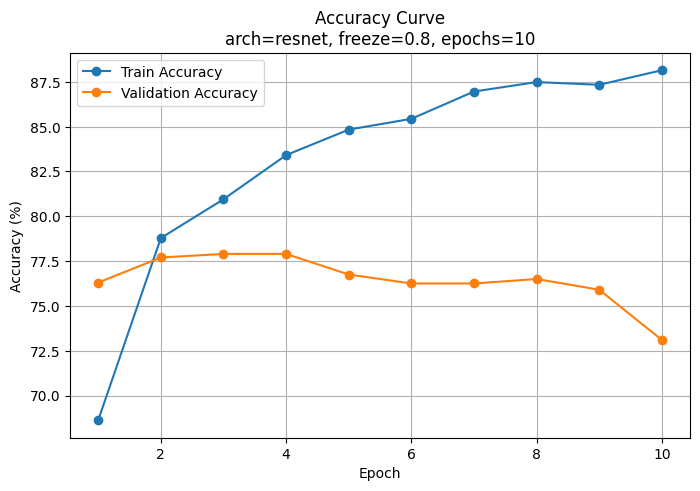

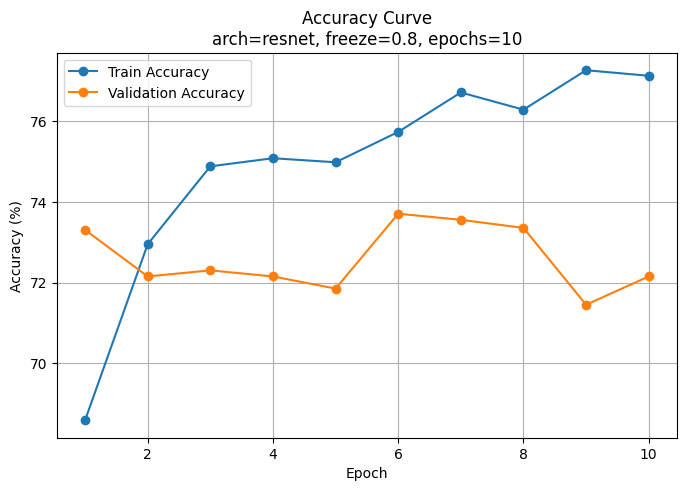

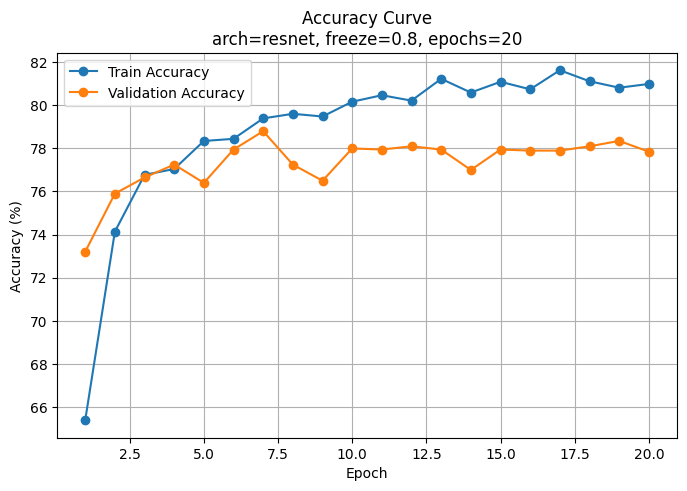

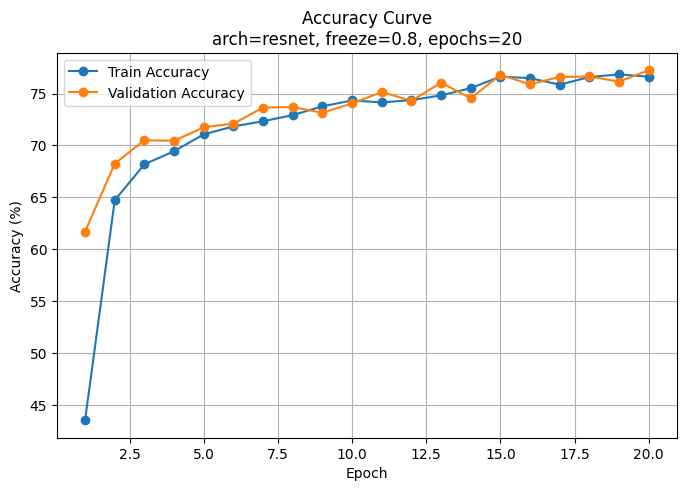

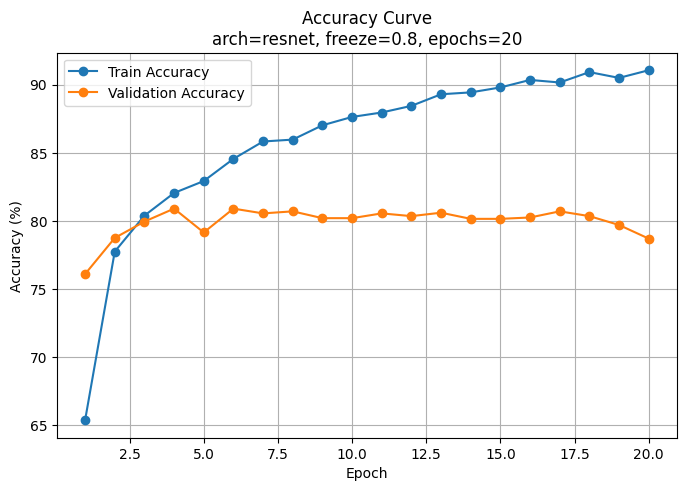

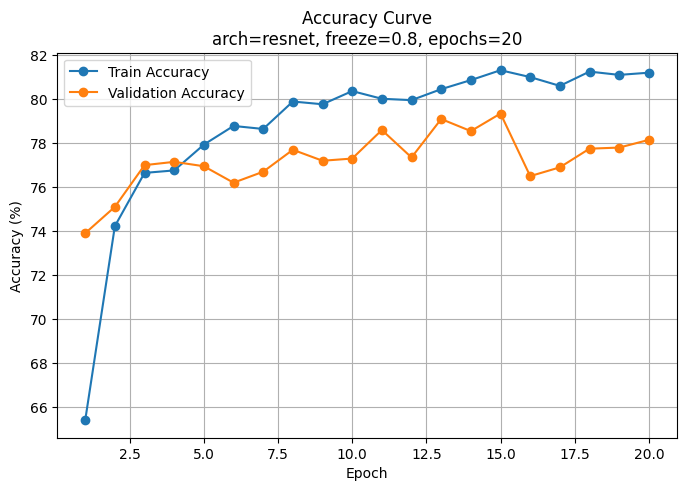

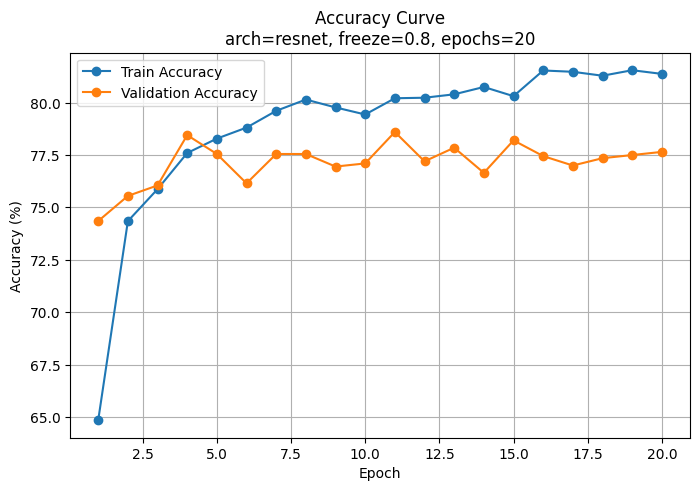

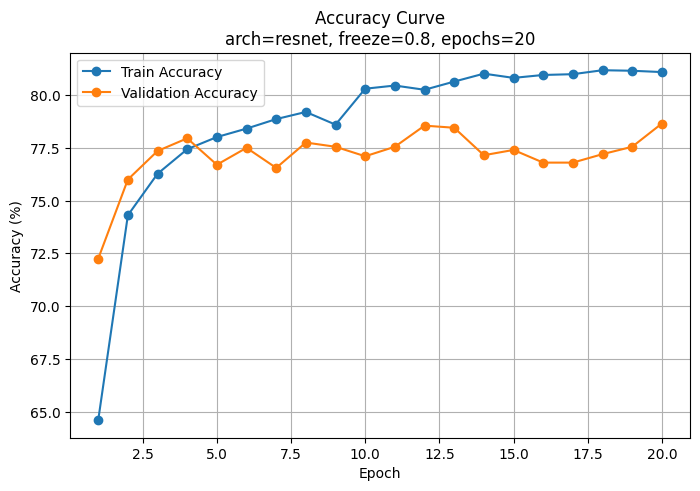

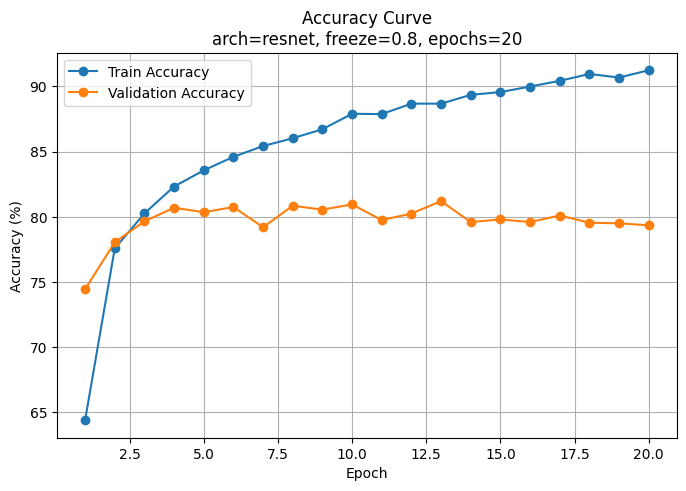

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
import wandb  # for logging and visualization

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to get the pretrained model with some layers frozen
def get_model(name, freeze_ratio, last_only=False):
    # If architecture is ResNet
    if name == 'resnet':
        weights = ResNet50_Weights.DEFAULT  # Load default pretrained weights
        model = models.resnet50(weights=weights)  # Load pretrained ResNet50 model
        num_features = model.fc.in_features  # Get number of input features to final FC layer
        model.fc = nn.Linear(num_features, 10)  # Replace final FC layer for 10 classes

    # If architecture is Inception
    elif name == 'inception':
        weights = Inception_V3_Weights.DEFAULT
        model = models.inception_v3(weights=weights)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)  # Replace final FC layer for 10 classes

    # Option to freeze all layers except the final one
    if last_only:
        for param in model.parameters():
            param.requires_grad = False  # Freeze all layers
        for param in model.fc.parameters():
            param.requires_grad = True  # Unfreeze final FC layer only
    else:
        # Freeze only a certain ratio of layers from the beginning
        total = sum(1 for _ in model.children())  # Count total layers
        freeze_layers = int(freeze_ratio * total)  # Number of layers to freeze
        for idx, child in enumerate(model.children()):
            for param in child.parameters():
                param.requires_grad = idx >= freeze_layers  # Freeze first part, unfreeze the rest

    return model  # Return customized model


# Function to load and preprocess the dataset
def prepare_data(data_path, augment=False):
    # Apply data augmentation if specified
    if augment:
        tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    else:
        # Simple resizing and normalization for validation
        tfms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

    # Load dataset from folders
    full_data = ImageFolder(data_path, transform=tfms)

    # Split indices for training and validation (80-20 split)
    train_idx, val_idx = train_test_split(range(len(full_data)), test_size=0.2, random_state=42)

    # Create data loaders
    train_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(train_idx))
    val_loader = DataLoader(full_data, batch_size=32, sampler=SubsetRandomSampler(val_idx))
    return train_loader, val_loader

import matplotlib.pyplot as plt

# Function to train the model and validate it after each epoch
def run_training(model, train_dl, val_dl, num_epochs, cfg):
    model.to(device)  # Move model to GPU if available
    loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    #optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0
        correct = 0
        total = 0

        # Iterate over training batches
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(imgs)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)  # Get class predictions
            correct += (preds == labels).sum().item()  # Count correct predictions
            total += labels.size(0)

        avg_loss = total_loss / len(train_dl)
        train_acc = 100 * correct / total  # Training accuracy
        train_acc_list.append(train_acc)

        # Log training metrics to WandB
        wandb.log({"Train Loss": avg_loss, "Train Accuracy": train_acc})

        # Validation loop (no gradient updates)
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_acc = 100 * correct_val / total_val  # Validation accuracy
        val_acc_list.append(val_acc)

        # Log validation metrics to WandB
        wandb.log({"Validation Accuracy": val_acc, "Epoch": epoch + 1})

        # Print training progress
        print(f"Epoch {epoch + 1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    print("Training finished.")

    # Plot and save the accuracy graph
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_acc_list, label="Train Accuracy", marker='o')
    plt.plot(range(1, num_epochs + 1), val_acc_list, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Accuracy Curve\narch={cfg.architecture}, freeze={cfg.freeze_ratio}, epochs={cfg.epochs}")
    plt.legend()
    plt.grid(True)

    # Save the accuracy plot as an image
    filename = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}.png"
    plt.savefig(filename)
    print(f"Saved accuracy plot as {filename}")


# WandB sweep configuration for trying different hyperparameters automatically
sweep_configuration = {
    'method': 'bayes',
    'metric': {'name': 'Validation Accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [10, 15, 20]},
        'freeze_ratio': {'values': [0.8]},
        'architecture': {'values': ['resnet']},
        'learning_rate': {'values': [0.001, 0.0001, 0.01]},
        'augment': {'values': [True, False]}
    }
}


# Login to Weights & Biases using your API key
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")
# Initialize sweep in WandB with given configuration
sweep_id = wandb.sweep(sweep=sweep_configuration, project="A2_PartB_finetune_bayes")


# Function that runs for each sweep iteration
def sweep_runner():
    with wandb.init() as run:  # Start a new wandb run
        cfg = wandb.config  # Access configuration parameters
        wandb.run.name = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}"

        # Get the model based on config
        model = get_model(cfg.architecture, cfg.freeze_ratio, last_only=False)

        # Prepare training and validation data
        data_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"
        #train_dl, val_dl = prepare_data(data_dir, augment=False)
        train_dl, val_dl = prepare_data(data_dir, augment=cfg.augment)


        # Train the model and log results
        run_training(model, train_dl, val_dl, num_epochs=cfg.epochs, cfg=cfg)


# Start the sweep agent, run sweep_runner once
wandb.agent(sweep_id, function=sweep_runner, count=10)
# Finish WandB run
wandb.finish()

Create sweep with ID: wo0oc54y
Sweep URL: https://wandb.ai/viinod9-iitm/transfer_learning_sweep/sweeps/wo0oc54y


wandb: Agent Starting Run: 19a0ovbo with config:
wandb: 	architecture: resnet
wandb: 	augment: True
wandb: 	epochs: 1
wandb: 	freeze_ratio: 0.8
wandb: 	learning_rate: 0.001


Epoch 1/1 | Train Acc: 64.20% | Val Acc: 73.65%
Training finished.
Saved accuracy plot as arch-resnet_freeze-0.8_ep-1.png
Test Accuracy: 79.05%


Epoch,▁
Test Accuracy,▁
Train Accuracy,▁
Train Loss,▁
Validation Accuracy,▁
Epoch,1
Test Accuracy,79.05
Train Accuracy,64.19552
Train Loss,1.25568
Validation Accuracy,73.65


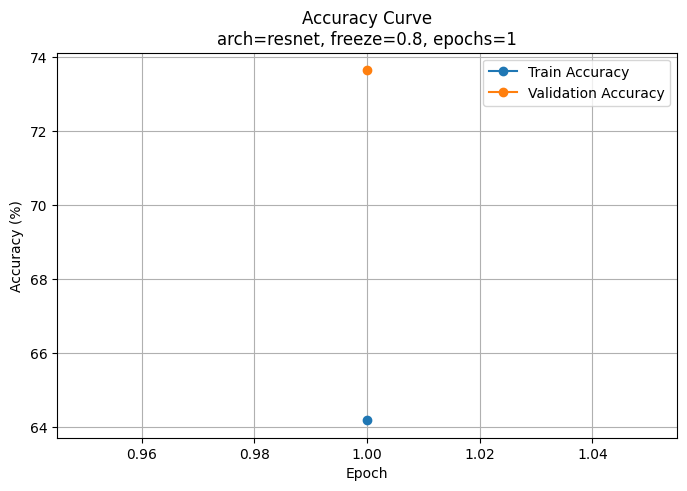

In [6]:
def load_test_data(val_dir, batch_size=32):
    tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    test_data = ImageFolder(val_dir, transform=tfms)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    class_names = test_data.classes
    return test_loader, class_names


def predict_and_log_images(model, test_loader, class_names):
    model.eval()
    all_images = []
    count_per_class = {cls: 0 for cls in class_names}
    max_per_class = 3  # Only 3 per class
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            for img, pred, actual in zip(imgs, preds, labels):
                pred_class = class_names[pred.item()]
                actual_class = class_names[actual.item()]
                if count_per_class[actual_class] < max_per_class:
                    all_images.append(wandb.Image(img.cpu(), caption=f"Pred: {pred_class} | Actual: {actual_class}"))
                    count_per_class[actual_class] += 1
            if all(count >= max_per_class for count in count_per_class.values()):
                break
    wandb.log({"Predicted vs Actual (10x3)": all_images})


def sweep_runner():
    with wandb.init() as run:
        cfg = wandb.config
        wandb.run.name = f"arch-{cfg.architecture}_freeze-{cfg.freeze_ratio}_ep-{cfg.epochs}_lr-{cfg.learning_rate}_aug-{cfg.augment}"

        model = get_model(cfg.architecture, cfg.freeze_ratio, last_only=False)
        data_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/train"
        val_dir = "/kaggle/input/inaturalist-dataset/inaturalist_12K/val"

        train_dl, val_dl = prepare_data(data_dir, augment=cfg.augment)
        run_training(model, train_dl, val_dl, num_epochs=cfg.epochs, cfg=cfg)

        # 🔽 Evaluate on test set
        test_loader, class_names = load_test_data(val_dir)
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        test_acc = 100 * correct / total
        print(f"Test Accuracy: {test_acc:.2f}%")
        wandb.log({"Test Accuracy": test_acc})

        # Log image grid
        predict_and_log_images(model, test_loader, class_names)



sweep_config = {
    'method': 'random',  # or 'grid', 'bayes'
    'metric': {'name': 'Validation Accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [1]},
        'freeze_ratio': {'values': [0.8]},
        'architecture': {'values': ['resnet']},
        'learning_rate': {'values': [0.001]},
        'augment': {'values': [True]}
    }
}




sweep_id = wandb.sweep(sweep_config, project="transfer_learning_sweep")
wandb.agent(sweep_id, function=sweep_runner, count=1)  # or count=None for indefinite